<a href="https://colab.research.google.com/github/sscs-ose/sscs-ose-chipathon.github.io/blob/main/template_notebook_to_follow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PMIC for lab-bench-on-chip

```
AC3E-UTFSM-PUC-Chile-Uruguay Team, February 2023
SPDX-License-Identifier: Apache-2.0
```


|Name|Email|Affiliation|IEEE Member|SSCS Member|
|:--:|:--:|:----------:|:----------:|:----------:|
|Aquiles Viza Vergara|aquiles.viza@sansano.usm.cl | Universidad Técnica Federico Santa María|No|No|
|Daniel Arevalos Ortiz|daniel.arevalos@sansano.usm.cl| Universidad Técnica Federico Santa María|Yes|Yes|
|Max Vega Campos|max.vega@usm.cl|Universidad Técnica Federico Santa María|No|No|
|Shawn Rodrigues|shawn.rodrigues@usm.cl|Universidad Técnica Federico Santa María|No|No|
|Vicente Ramirez|vicente.ramirez@usm.cl|Universidad Técnica Federico Santa María |No|No|
|Alfonso Cortés Neira|alfonso.cortes@sansano.usm.cl|Universidad técnica Federico Santa María|Yes|Yes|
|Andrés Martínez|andres.martinezf@sansano.usm.cl|Universidad técnica Federico Santa María|No|No|
|Joel Gak|jgak@ucu.edu.uy|Universidad Católica de Uruguay|Yes|Yes|
|Matías Miguez|mmiguez@ucu.edu.uy|Universidad Católica de Uruguay|Yes|Yes|
|Nicolás Calarco|ncalarco@ucu.edu.uy |Universidad Católica de Uruguay|Yes|Yes|
|Jorge Marín (Lead) <br />|jorge.marinn@usm.cl|AC3E|Yes|Yes|
|Christian Rojas|c.a.rojas@ieee.org|AC3E, Universidad Técnica Federico Santa María|Yes|No|
|Mustafa Labbad | mustafaellabad@gmail.com | Mabrains |No|No|
|Amro Tork (Advisor) |amro_tork@mabrains.com|Mabrains|No|No|

**_Abstract_** - Current advances in integration technologies allows to put an entire system on a single chip die. This level of integration has a lot of challenges, one of the most relevant is power integrity to ensure all the building blocks within the ASIC receive the required supply voltage/current levels with noise levels within their specifications. In this project, the main focus is on the power management unit for the Chipathon 2023 Lab-Bench On Chip. The aim is to analyze the potential of the DCDC-LDO on chip signal chain, using building blocks available in the SKY130 technology, and study, desing and implement from specification to GDS a system for two (or more) regulated supplies in the GlobalFoundries’ GF180MCU technology.

**_Key words_** - PMU; PMIC; Power Management; LDO; Buck Converter; Microelectronics.


## Tools and input files

### Install tools and dependencies

The cells below will install all the necessary tools to excecute this notebook. It is highly recommended to run this notebook in **Google Colab**, as it was tested in that environment.

In [1]:
##@title Install dependencies {display-mode: "form"}
##@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

#ngspice_version = 'latest' #@param {type:"string"}
#gf180mcu_fd_pr_version = 'latest' #@param {type:"string"}

ngspice_version = 'latest'
gf180mcu_fd_pr_version = 'latest'

if ngspice_version == 'latest':
  ngspice_version = ''

if gf180mcu_fd_pr_version == 'latest':
  gf180mcu_fd_pr_version = 'main'

import os
import pathlib
from pathlib import Path
import urllib.request

import pandas as pd
import matplotlib.pyplot as plt
import altair as alt


!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     ngspice={ngspice_version} \
                     iverilog \
                     open_pdks.sky130a > \dev\null

ngspice_models_dir = Path('globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice')
ngspice_models_dir.mkdir(exist_ok=True, parents=True)
models = ['design.ngspice', 'sm141064.ngspice', 'sm141064_mim.ngspice', 'smbb000149.ngspice']
for m in models:
  url = f'https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/{gf180mcu_fd_pr_version}/models/ngspice/{m}'
  print('downloading:', url)

  # Try with this
  # !wget -P {gf180_ngspice_url}/{m}
  with urllib.request.urlopen(url) as src:
    with (ngspice_models_dir / m).open('wb') as dst:
      dst.write(src.read())

PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env
downloading: https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/main/models/ngspice/design.ngspice
downloading: https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/main/models/ngspice/sm141064.ngspice
downloading: https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/main/models/ngspice/sm141064_mim.ngspice
downloading: https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/main/models/ngspice/smbb000149.ngspice
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:

### Download input files
This code block will clone all the necessary input files.

In [2]:
path = {
  "project": Path("PMIC_lab-on-chip_power-management").resolve(),
}

# Repo download
###############
git_repo = "https://github.com/lild4d4/PMIC_lab-on-chip_power-management.git"

if not path["project"].exists():
  !git clone {git_repo}
else:
  print("Erasing project")
  !rm -rf {path["project"]}
  !git clone {git_repo}

Erasing project
Cloning into 'PMIC_lab-on-chip_power-management'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 77 (delta 25), reused 56 (delta 8), pack-reused 0
Unpacking objects: 100% (77/77), 667.59 KiB | 2.70 MiB/s, done.


### Tools configuration

In [3]:
%%writefile .spiceinit
set ngbehavior=hs
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
*set ngbehavior=hsa
* "nomodcheck" speeds up loading time
*set ng_nomodcheck

Overwriting .spiceinit


### References to important files and directories

In [4]:
# Path variables
################

path["sky130_base"]       = Path("conda-env").resolve()
path["sky130_ngspice"]    = path["sky130_base"] / "share" / "pdk" / "sky130A" / "libs.tech" / "ngspice"
path["sky130_xschem"]     = path["sky130_base"] / "share" / "pdk" / "sky130A" / "libs.tech" / "xschem"

path["project_ldo"]       = path["project"] / "LDO"
path["project_ldo_spice"] = path["project"] / "LDO" / "ldo_v2.spice"
path["project_ldo-spice"] = path["project"] / "LDO" / "ldo_v2.spice"

path["project_dcdc"]      = path["project"] / "DC-DC Converter"
path["project_dcdc-core_testbench_wfilter_vfinal"] = path["project_dcdc"] / "core_testbench_wfilter_vfinal.spice"

# path["Figures"] = path["project"] / "Figures/dc-dc_converter_schm"

for resource in path.values():
  if not resource.exists():
    print(f"file {resource} doesn't exists")

# Specific file verification
##############################

if not (path["sky130_ngspice"] / "sky130.lib.spice").exists():
  print("sky130 spice doesn't exist!")

## I. Introduction

Power management is an unavoidable concern in aplication integrated circuits (ASIC) design projects. The importance of power considerations gets even more critical when we consider future energy autonomous systems such as the one depicted in Figure 1, which represents a sensor node with energy harvesting capabilities and analog, mixed signal and digital on-chip blocks. The most challenging blocks downstream towards the functional building blocks are the DCDC and the LDO(s) and their configurations, highlighted in Figure 1. In previous works, this problem has been considered by eliminating the LDO and replacing it by an active filter [1] or by considering different DCDC-LDO on-chip or off-chip configurations, depending on the requirements [2]. In this project, we will focus on a full on-chip solution, and thus we will analyze the efficiency, area/speed performance and interference among power channels for an implementation using the GF180 opensource CMOS technology.

<div align="center">

<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/green-electronics-microsystem.png" width=900/>

Figure 1: Green electronics sensor node motivation example - the project target blocks are enclosed in green shapes [3]
</div>


In the context of the 2023 SSCS "PICO" Chipathon competition, and inspired by the problem described above, the objective of this project is to design a power management module for a lab-bench-on-chip. The proposed PMIC includes a DC-DC converter and Low-Droput regulator modules, as can be seen in Figure 2 (a). Figure 2 (b) shows an example of the number of regulated independant supplies required by other blocks of the lab-bench-on-chip architecture, such as an ADC. Both the converter and the LDO will be re-designed based on existing open-source projects that target Skywater 130nm technology:
* **DC-DC**: 3-Level Flying Capacitor Converter, previous work from the AC3E-UTFSM team for the 2022 Chipathon [4] and the Code-a-Chip competition [5].
* **LDO**: low dropout regulator in Caravel harness by Mabrains [6], advisors of the project.

The designs from these reference projects will be modified to target Global Foundries 180nm, while adjusting their specifications so that the entire PMIC system can supply the voltage/current levels required by the other blocks in the lab-bench-on-chip architecture.

<div align="center">

<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/System_diagram.png" width=700/>

Figure 2: Design target in (a) including a cascade of a DCDC and severlal LDO blocks, and (b) a proposed load of interest consisting of a SAR ADC including digital and analog building blocks.
</div>

As we design the proposed PMIC, we aim to add value to the project by addressing the following challenges:
* **Automated layout generation**: previous work of the team on power transistors layout will be improved, and the automated generation of the LDO layout will also be explored. 
* **Technology node portability**: while changing the target node of existing proyects with focus on automatic layout generation, a generalized aproach can be explored to facilitate technology portability.

Further, the automated specs-to-GDS flow for the entire DCDC-LDO system can be achieved. The final goal is to generate layout realizations from a list of specs such as supply voltage/current levels and maximum ripple.

## II. Implementation Details of your Idea

In the following subsections, it will be decribed the most relevant building blocks needed to implement the power management core used to generate the on-chip supplies for the lab-bench-on-chip building blocks, including the selected topologies (which may vary after finishing the preliminary study). Main design parameters and some initial simulations are presented.

### 3-level flying capacitor DCDC converter stage

This subsection describes the 3-Level Flying Capacitor Converter (3LFCC) topology to be used in the project. A previous implementation of this converter using the SKY130 technology shows good simulated efficiency and ripple performance [8]. Furthermore, an automated generator flow which provides a GDS file from high-level specs such as the output current and the total chip area has been implemented in [5]. Therefore, this building block can be generated after adapting the automated flow to the GF180 PDK technology, and is a good initial choice for our design.




The DCDC block initial specifications, provided in the Table I, are based on privious results with the topology [5][8]. This specifications will be adapted along the project development to match the requirements of the lab-bench-on-chip power consumption profiles, which are a priori unknown.

|Parameter |Value |Units|
|:--:|:--:|:----------:|
|Vin|5|V|
|Vout|~3.3 |V|
|Iout_max | 1 - 150|mA|
|Switching Frequency |  1|MHz|
|Rated Power | > 0.5|W|
|Target Max. Efficiency | > 90 |%|\

Table I: DCDC Specs

<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/dc-dc_converter_schm.png" width=600/>

Figure 3: 3LFC Converter schematic
</div>

The main components of the converter are described below.

#### Subcircuit-level design:


1.   Power Stage:

This module consists of the four power transistors (two PMOS and two NMOS devices) which switch the flying capacitor electric position to generate the needed output states for the DCDC module. They constitute the most area consuming part of the system, since their ON resistance (as low as posible) is inversely proportional to their area, and thus static efficiency directly depends on their sizing. Therefore, they need to be optimized for the required power consumption. The main challenge regarding this block is to translate the know-how obtained for the SKY130 technology to the GF180 technology, which has not been verified in post-silicon measurements.

<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/dc_power-stage.png" width=200/>

Figure 4: Power Stage Schem
</div>

2. Gate Drivers

The implemented gate drivers [7] need to charge and discharge the power MOS gates in a minimum time, to perform according to the frequency specifications of the system. The transistion time is relevant to define the dead time needed in the digital switching input signals, which are provided off-chip in our implementation.

The main parameter is the gate driver output stage strength, which defines how much current can be driven or sunk by the circuit. We intend to include this parameter in the automated layout generator [5], specifically for the GF180 technology.

Further work could integrate dead-time generation or the complete control loop in order to reduce the number of pins required to control the converter.

3. Flying Capacitor

In the proposed implementation, opposite to the work in [8], the flying capacitors are placed off chip, to optimize chip area and thus silicon costs. The drawback are the parasitics introduced by the bonding wires, the package, the PCB traces and the discrete capacitance components. These factors need to be analyzed in the context of the GF180 technology. 

4. Output Filter

An LC low-pass filter is used to reduce output ripple. It must be designed according to switching frequency and ripple specifications. Since the area required for the passive components can be excessively large, we propose the use of off-chip inductor and capacitor.  



#### 3LFCC preliminary simulations

The following cell shows a transient simulation of the 3LFCC from [4], with 2 cores, 300mA output current per core, and including an off-chip LC filter. The plot shows the output waveform when converting from 5V to ~3.3V, with a ripple around 100mV peak-to-peak.

The used of multiple interleaved cores can reduce ripple, and therefore passives area, with the cost of increasing rhe number of pins. Preliminarily, a single core converter is considered for the current project. However, the trade-offs associated to usign multi-core can also be considered, based on previous work.


In [5]:
# Simulation Setup
##################
!rm -rf dc-dc.txt
# Remove "DC-DC Converter" and put "DC-DC_Converter" or something like that
!ngspice -b "{path['project_dcdc-core_testbench_wfilter_vfinal']}" &> /dev/null

Output current (desired output): 0.1511217176382795 A
Efficiency (at desired current output): 93.48352432638339 %
Voltage (at desired current output): 3.3246777880091556 V


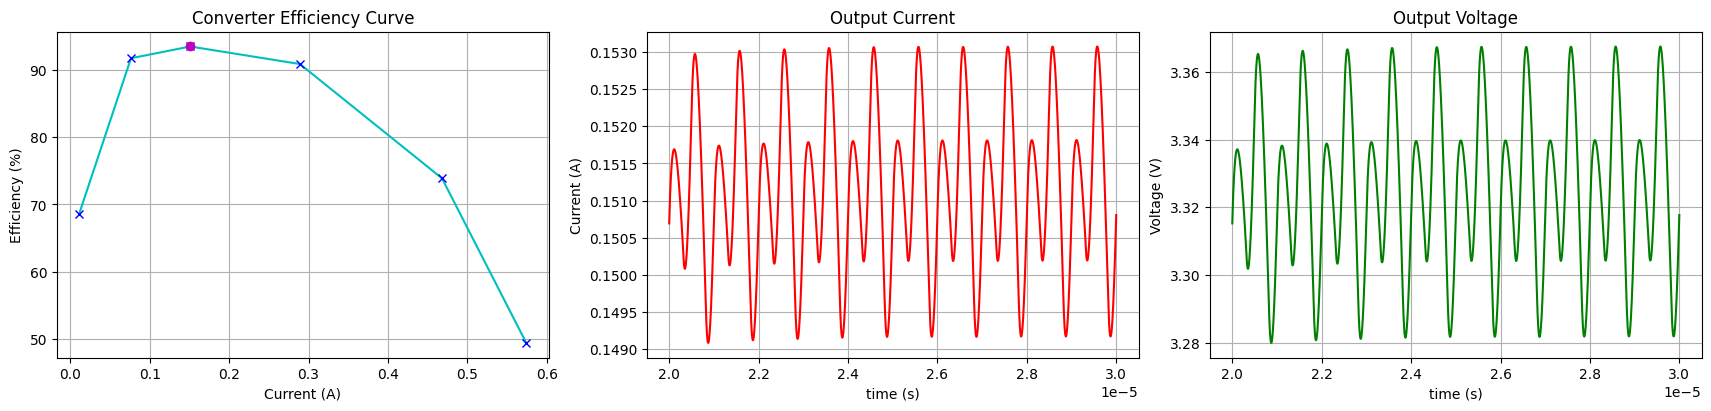

In [6]:
# Simulation analysis
#####################
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_csv('dc-dc.txt',delim_whitespace=True, header=None,names=['t', 'v', 't1', 'i1','t2','v2','t3','i','o','g']).values
eff_arr=[]
curr_arr=[]
r=[1,2,3,4,5,6]
indices=[]
for res in r:
    i=0
    for number in data:
        if round(number[0],13)==0.00002 and i not in indices:
            row1=i
            indices.append(i)
        if round(number[0],13)==0.00003 and i not in indices:
            row2=i
            indices.append(i)
            break
        i+=1
    v_out = data[row1:row2,1]
    i_in = (-1)*data[row1:row2,3]
    i_out = data[row1:row2,7]
    vout = np.mean(v_out)
    iin = np.mean(i_in)
    iout = np.mean(i_out)
    pout = vout*iout
    vin=5
    pin = vin*iin
    filter_eff = (pout/pin)*(100)
    if res==3:
        pre_lay_sis_filter_eff=filter_eff
        pre_lay_sis_filter_curr=iout
        pre_lay_sis_filter_volt=vout
        curr_trace=i_out
        v_trace=v_out
        time=data[row1:row2,6]
    eff_arr.append(filter_eff)
    curr_arr.append(iout)
print('Output current (desired output):',pre_lay_sis_filter_curr,'A')
print('Efficiency (at desired current output):',pre_lay_sis_filter_eff,'%')
print('Voltage (at desired current output):',pre_lay_sis_filter_volt,'V')

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(17,4))
axs[0].plot(curr_arr,eff_arr,color='c')
axs[0].plot(curr_arr,eff_arr,'bx')
axs[0].plot(pre_lay_sis_filter_curr,pre_lay_sis_filter_eff,'mo')
axs[0].set_title('Converter Efficiency Curve')
axs[0].set_xlabel('Current (A)')
axs[0].set_ylabel('Efficiency (%)')
axs[0].grid()

axs[1].plot(time,curr_trace,color='r')
axs[1].set_xlabel('time (s)')
axs[1].set_title('Output Current')
axs[1].set_ylabel('Current (A)')
axs[1].grid()

axs[2].plot(time,v_trace,color='g')
axs[2].set_xlabel('time (s)')
axs[2].set_title('Output Voltage')
axs[2].set_ylabel('Voltage (V)')
axs[2].grid()
plt.show()

### Regulation stage

This subsection describes the Low Drop-Out topology proposed for the project. A previous implementation of this LDO regulator using the SKY130 technology was developped at Mabrains (who are part of the advisors of this proposal) [6]. The design in the reference project must be reproduced targeting GF180 technology, then adapted to supply 3.3 volts and scaled to provide the maximum current required by other blocks of the lab-bench-on-chip.

Figure 5 shows the main modules of the regulator, which are described below.


<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/ldo_schem.png" width=600/>

Figure 5: LDO schematic.
</div>

####  Subcircuit-level design:



1.   Error Amplifier

The error amplifier in an LDO performs the function of comparing the output voltage of the LDO with a reference voltage and generating an error signal that is used to adjust the output voltage.
As a result, the LDO can maintain a stable output voltage even when the input voltage or load current varies. The design of the error amplifier is critical to the performance of the LDO.


<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/error-amp_schem.png" width=600/>

Figure 6: Error ampliofier schematic.
</div>

2.   Bandgap

Bandgap subcircuit is  used to generate a stable and accurate internal voltage reference. This technique uses the characteristics of semiconductor material to generate a fixed reference voltage. This reference voltage is used to control the feedback circuit of the LDO and maintain a constant output voltage as the load or input voltage changes.


<div align="center">
<img src="https://github.com/lild4d4/PMIC_lab-on-chip_power-management/raw/main/Figures/bandgap_schem.png" width=1000/>

Figure 7: Bandgap schematic.
</div>

The specifications of the reference project can be seen in the Table II [6]:

| Specification             | TT                           |
| ------------------------- | ---------------------------- |
| Temperature Coefficient   | 49.4 ppm/°C                  |
| Dropout Voltage @IL=0.1mA | 0.211mV                      |
| Dropout Voltage @IL=10mA  | 85.6mV @IL=10mA              |
| Dropout Voltage @IL=100mA | 168.45mV @IL=100mA           |
| Line Regulation           | 0.0325 mv/v                  |
| Load Regulation           | 0.06mV IL=0.1mA till IL=10mA |
| PSRR @ 100Hz              | 88.1dB                       |
| PSRR @ 100kHz             | 44.7dB                       |
| Load range                | 50uA -> 100mA                |
| Phase Margin              | 50.1°                        |
| Quiescent Current         | 130uA                        |
| Startup time              |     7uS|

Table II: LDO Specs


The aim is to:
1. Convert this design to GF180 and check if we can achieve similar performance.
2. Scale the current drive capabilities to match our requirements according to the case study load, e.g. one for analog loads and one for digital loads.
3. Explore layout methods to increase robustness against process variation, as well as automated layout generation.


#### LDO preliminary simulations

The cell below runs a simulation of the LDO from [6]. The ploted curves show correct regulation for a 1.8V supply output.

In [7]:
# Simulation Setup
##################
!rm -rf output.txt
!rm -rf supply_sweep.txt
!rm -rf PSRR_Analysis.txt
!rm -rf Stability_Analysis.txt
!rm -rf Transient.txt

!ngspice -b {path["project_ldo-spice"]} &> /dev/null

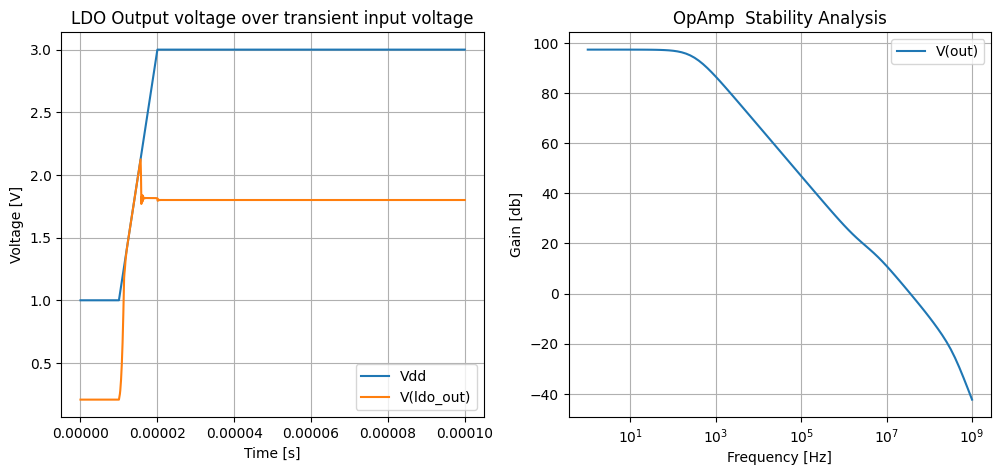

In [8]:
# Simulation Analysis
#####################
df1 = pd.read_csv("Stability_Analysis.txt", delim_whitespace=True)
df1.columns = ["Frequency [Hz]", "V(out)"]
df2 = pd.read_csv("Transient.txt", delim_whitespace=True)
df2.columns = ["Time [s]", "Vdd", "V(ldo_out)"]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 5, forward=True)

ax[0].set_title("LDO Output voltage over transient input voltage")
ax[0].set_ylabel("Voltage [V]")
df2.plot(x="Time [s]", y="Vdd", grid=True, ax=ax[0])
df2.plot(x="Time [s]", y="V(ldo_out)", grid=True, ax=ax[0])

ax[1].set_title("OpAmp  Stability Analysis")
ax[1].set_ylabel("Gain [db]")
ax[1].set_xscale('log')
df1.plot(x="Frequency [Hz]", y="V(out)", grid=True, ax=ax[1])
fig.show()

## III. Summary of the idea

The main objective is to implement a full DCDC converter + LDO power management system from specifications to GDS/Tapeout, while exploring the capabilities of the GF180 technology to perform these kind of functions, compared to previous work in SKY130. The architecture and the initial building blocks will be based on the description above, but further reserch on the specific aspects of this technology may motivate other topology choices.

A secondary objective of the project is to focus on analog mixed-signal IC design automation starting on early design stages. An initial target is to extend our previous work using scripted layout generators for the building blocks of the system, focused until now on the 3LFCC DCDC, but now including the LDO design. Later, aspects such as technology portability (e.g. between the SKY130 and the GF180 technologies) can be considered, if time allows it.

Furthermore, the consolidation of colaborative work of the involved reserch groups will be a milestone for this project.

### System specifications

System specifications consist mainly in characteristics of the regulated outputs, which depend on the requirements of the other blocks in the lab-bench-on-chip architecture. These are: output voltage, maximum current and maximum ripple. Input voltage will be standard 5V and output voltage of the LVOs will be 3.3V as defined in GF180.

Collaborting with the SAR ADC project, from AC3E-UTFSM team, will provide us with real values for the maximum current and ripple requirements.

|  Parameter  |   Value   | Units |
|-------------|-----------|-------|
|     Vin     |     5     |   V   |
|  Vout$_i$   |  3.3 |   V   |
| Switching frequency | 1 | MHz |
| Iout$_{max}$ | to be defined | A |
| Ripple | to be defined | V |


## IV. Planification and Tasks

Team members are currently divided in subgroups dedicated to each module of the PMIC. The next steps for each group focus in consolidating the simulations to caracterize each module and subsystem. Layout generation will be explored gradually until system level simulations achieve the required performance. 

Several milestones are considered, including 2 design reviews with team advisors and other collaborators.

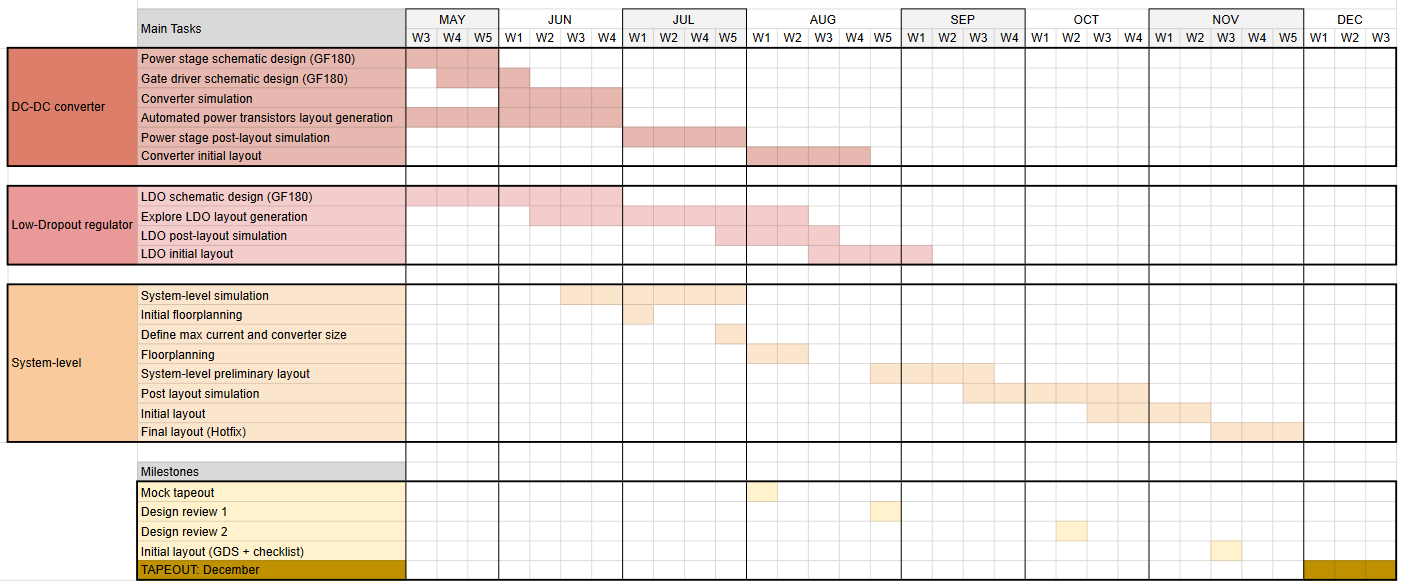

## V. References


[1] S. Kose, S. Tam, S. Pinzon, B. McDermott and E. G. Friedman, "Active Filter-Based Hybrid On-Chip DC–DC Converter for Point-of-Load Voltage Regulation," in IEEE Transactions on Very Large Scale Integration (VLSI) Systems, vol. 21, no. 4, pp. 680-691, April 2013, doi: 10.1109/TVLSI.2012.2190539.

[2] I. Vaisband and E. G. Friedman, "Heterogeneous Methodology for Energy Efficient Distribution of On-Chip Power Supplies," in IEEE Transactions on Power Electronics, vol. 28, no. 9, pp. 4267-4280, Sept. 2013, doi: 10.1109/TPEL.2012.2230408.

[3] John Hu, Mohammed Ismail, "CMOS High Efficiency On-chip Power Management", September 2011, doi: 10.1007/978-1-4419-9526-1

[4] https://github.com/JorgeMarinN/3LFCC_AC3E_Tapeout

[5] https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/VLSI23/accepted_notebooks/3LFCC/3LFCC_v2p0.ipynb

[6] https://github.com/mabrains/caravel_user_project_ldo

[7] Gak, J., Miguez, M., & Arnaud, A. (2021). CMOS Level Shifters from 0 to 18 V Output. Analog Integr. Circuits Signal Process., 107(3), 617–628.

[8] J. Marin et al., "Integrated Three-Level Flying Capacitor DC-DC Buck Converter for CubeSat Applications," 2023 Argentine Conference on Electronics (CAE), Cordoba, Argentina, 2023, pp. 90-95, doi: 10.1109/CAE56623.2023.10087013.
